<a href="https://colab.research.google.com/github/rinogrego/Bone-Age-Assessment-with-MobileNetV2/blob/main/bone_age_regression_with_mobilenetv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Data

In [ ]:
# !mkdir '/content/drive/MyDrive/Bone-Age-Regression'

In [ ]:
DATASET_TARGET_PATH = '/content/drive/MyDrive/Dataset/Bone Age Regression/'

In [ ]:
!unzip -q '/content/drive/MyDrive/Bone-Age-Regression/bone-age-regression.zip' -d '/content/drive/MyDrive/Dataset/Bone Age Regression/'

# Import Package

In [ ]:
from typing import Iterator, List, Union, Tuple, Any
from datetime import datetime

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Model, regularizers
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import History

# Dataframe Processing

In [ ]:
df = pd.read_csv(f'{DATASET_TARGET_PATH}/train.csv')
df = df.sort_values(by='fileName')[:]
# df['gender'] = df['male'].map(lambda x: 1 if x==True else 0)
df['gender'] = df['male'].map(lambda x: 'male' if x==True else 'female')
df = df.drop(['male'], axis=1)
df

,fileName,boneage,gender
3957,10000.png,96,male
10831,10001.png,168,male
132,10002.png,168,male
3494,10003.png,76,female
9580,10004.png,135,male
...,...,...,...
4458,9995.png,94,female
521,9996.png,94,female
5916,9997.png,144,female
1399,9998.png,69,female


In [ ]:
# # Split dataframe by gender
# df_male = df.where(df['gender'] == 1).dropna()
# df_female = df.where(df['gender'] == 0).dropna()

In [ ]:
# # Take some observations from each dataframe
# df_male_subset = df_male.sample(n=2000)
# df_female_subset = df_female.sample(n=2000)

In [ ]:
# # Combine dataframes
# df = pd.concat([df_male_subset, df_female_subset], axis=0)

# Callback Initialization

In [ ]:
class CustomSaver(keras.callbacks.Callback):
  def __init__(self, model_name):
    self.model_name = model_name

  def on_epoch_end(self, epoch, logs={}):
    if (epoch+1) % 10 == 0:  # or save after some epoch, each 10-th epoch etc.
      self.model.save("drive/MyDrive/Projects/Bone Age Regression/{}_{}_epochs.h5".format(self.model_name, epoch+1))
      print("\nModel Saved at {} epochs".format(epoch+1))

from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("best_model.hdf5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto', save_freq=1)

# Function for Saving Model and History

In [ ]:
def save(model, model_name, version, history, epoch=None, current_epoch=0, batch_size=32):
  # cek existing history
  assert epoch != None
  try:
    # if past training history existed
    old_history = pd.read_csv(f'drive/MyDrive/Projects/Bone Age Regression/hist_{version}_{model_name}_bs-{batch_size}_{current_epoch}_model.csv')
    df_history = pd.DataFrame({
      "loss": old_history['loss'].tolist() + history.history["loss"],
      "val_loss": old_history['val_loss'].tolist() + history.history["val_loss"],
      "mean_absolute_error": old_history['mean_absolute_error'].tolist() + history.history["mean_absolute_error"],
      "val_mean_absolute_error": old_history['val_mean_absolute_error'].tolist() + history.history["val_mean_absolute_error"],
    })
  except:
    # create new training history
    df_history = pd.DataFrame({
      "loss": history.history["loss"],
      "val_loss": history.history["val_loss"],
      "mean_absolute_error": history.history["mean_absolute_error"],
      "val_mean_absolute_error": history.history["val_mean_absolute_error"],
    })
  df_history.to_csv(f'drive/MyDrive/Projects/Bone Age Regression/hist_{version}_{model_name}_bs-{batch_size}_{epoch+current_epoch}_model.csv')
  print(f'History: {version}_{model_name} Saved!')
  model.save(f"drive/MyDrive/Projects/Bone Age Regression/{version}_{model_name}_bs-{batch_size}_{epoch+current_epoch}_epochs.h5")
  print(f'Model: {version}_{model_name}_bs-{batch_size}_{epoch+current_epoch}_epochs Saved!')
  return model, df_history

# Function for Drawing

In [ ]:
def plot_hist(df_hist, model_name, version, gender=None, batch_size=32, MAX_Y=30):
  print(df_hist)
  if gender:
    gender = 'Gender'
  else:
    gender = 'Non-Gender'
  data = df_hist.copy()
  data['Epochs'] = 0
  for i in range(len(data["Epochs"])):
    data["Epochs"][i] = i+1

  fig = plt.figure(figsize=(10, 6))
  ax1 = fig.add_subplot(111)

  ax1.scatter(data["Epochs"], data["mean_absolute_error"], s=10, c='b', marker="o", label='mean_absolute_error')
  ax1.scatter(data["Epochs"], data["val_mean_absolute_error"], s=10, c='r', marker="o", label='val_mean_absolute_error')
  plt.legend(loc='upper right')

  plt.gca().set_ylim([0, MAX_Y])
  plt.gca().set_xlim([0, len(data["Epochs"])+1])

  # https://stackoverflow.com/questions/24943991/change-grid-interval-and-specify-tick-labels-in-matplotlib
  # Major ticks every 20, minor ticks every 5
  x_ticks = np.arange(0, len(data["Epochs"])+1, 2)
  y_ticks = np.arange(0, MAX_Y+1, 5)

  ax1.set_xticks(x_ticks)
  ax1.set_yticks(y_ticks)

  plt.grid(True)
  plt.suptitle(f"{model_name} | {gender} | bs-{batch_size}")
  plt.xlabel("epochs")
  plt.ylabel("MAE")
  plt.savefig(f'drive/MyDrive/Projects/Bone Age Regression/plot_hist_{version}_{model_name}_{len(data)}_epochs')
  plt.show()

# Train-Validation-Test Split

In [ ]:
train_df, val_df = train_test_split(df, test_size=1/10, stratify=df['gender'])
train_df, test_df = train_test_split(train_df, test_size=1/9, stratify=train_df['gender'])

In [ ]:
train_df.head()

,fileName,boneage,gender
10131,9670.png,132,female
7844,5413.png,132,female
1605,2089.png,82,female
10454,7405.png,156,male
10878,12913.png,96,male


In [ ]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(9079, 3)
(1135, 3)
(1135, 3)


In [ ]:
print(train_df.describe())
print(val_df.describe())
print(test_df.describe())

           boneage
count  9079.000000
mean    127.324595
std      41.335236
min       1.000000
25%      96.000000
50%     132.000000
75%     156.000000
max     228.000000
           boneage
count  1135.000000
mean    125.522467
std      40.708985
min       9.000000
25%      94.000000
50%     132.000000
75%     156.000000
max     216.000000
           boneage
count  1135.000000
mean    127.717181
std      40.541618
min      12.000000
25%     100.000000
50%     132.000000
75%     156.000000
max     228.000000


# Custom Generator from DataFrame

In [ ]:
df_gen = ImageDataGenerator(rescale=1.0/255)

def gen_flow_for_two_inputs_from_dataframe(dataframe: pd.DataFrame):

  directory = f'{DATASET_TARGET_PATH}/images'

  genX1 = df_gen.flow_from_dataframe(
      dataframe=dataframe,
      directory=directory,
      x_col="fileName",
      y_col="boneage",
      class_mode="raw",
      target_size=(224, 224),
      validate_filenames=True
  )

  genX2 = df_gen.flow_from_dataframe(
      dataframe=dataframe,
      directory=directory,
      x_col="fileName",
      y_col="gender",
      class_mode="binary",
      target_size=(224, 224),
      validate_filenames=True
  )

  while True:
    X1 = genX1.next()
    X2 = genX2.next()
    yield [X1[0], X2[1]], X1[1]

In [ ]:
train_generator = gen_flow_for_two_inputs_from_dataframe(train_df)
validation_generator = gen_flow_for_two_inputs_from_dataframe(val_df)
test_generator = gen_flow_for_two_inputs_from_dataframe(test_df)

# MobileNetV2

In [ ]:
from tensorflow.keras.applications import MobileNetV2, DenseNet201, ResNet50

model_name = 'Bone-Age-MobileNetV2'
version = 'PreTrained-256-256-G-64-conc-256-256'

pre_trained_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# freeze layers of the pretrained model's
for layer in pre_trained_model.layers[:]:
    layer.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
# Flatten the pretrained model's output layers
feature_img = pre_trained_model.output
feature_img = layers.Conv2D(256, kernel_size=(2, 2), activation='relu')(feature_img)
feature_img = layers.Conv2D(256, kernel_size=(2, 2), activation='relu')(feature_img)
feature_img = layers.Flatten()(feature_img)

# Gender FC layers
input_gender = layers.Input(shape=(1,), name='Input-Gender')
feature_gender = layers.Dense(64, activation='relu', name='feature-layer-1')(input_gender)
# feature_gender = layers.Dense(64, activation='relu', name='feature-layer-2')(feature_gender)

feature = layers.concatenate([feature_img, feature_gender])

# Fully connected layer 1
x = tf.keras.layers.Dense(256, activation='relu')(feature)
x = tf.keras.layers.Dense(256, activation='relu')(x)

# Fully connected layer, output layer
out = tf.keras.layers.Dense(1, name="Output-Layer")(x)

model = tf.keras.models.Model(inputs=[pre_trained_model.input, input_gender], outputs=out, name=model_name)

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mean_absolute_error', metrics=[MeanAbsoluteError()], optimizer = adam)

# Fitting

In [ ]:
batch_size = 128
epochs = 20

train_size = len(train_df)
steps_per_epoch = train_size // batch_size

val_size = len(val_df)
validation_steps = val_size // batch_size

hist_model = model.fit(
    train_generator,
    epochs = epochs, 
    validation_data = validation_generator,
    steps_per_epoch = steps_per_epoch,
    validation_steps = validation_steps,
    callbacks = [CustomSaver(model_name)],
)

Epoch 1/20
70/70 [==============================] - ETA: 0s - loss: 26.3288 - mean_absolute_error: 26.3288Found 1135 non-validated image filenames.
Found 1135 non-validated image filenames belonging to 2 classes.
70/70 [==============================] - 318s 5s/step - loss: 26.3288 - mean_absolute_error: 26.3288 - val_loss: 24.5288 - val_mean_absolute_error: 24.5288
Epoch 2/20
70/70 [==============================] - 276s 4s/step - loss: 23.5379 - mean_absolute_error: 23.5379 - val_loss: 28.2515 - val_mean_absolute_error: 28.2515
Epoch 3/20
70/70 [==============================] - 372s 5s/step - loss: 21.8699 - mean_absolute_error: 21.8699 - val_loss: 27.6982 - val_mean_absolute_error: 27.6982
Epoch 4/20
70/70 [==============================] - 364s 5s/step - loss: 20.7002 - mean_absolute_error: 20.6994 - val_loss: 22.9377 - val_mean_absolute_error: 22.9377
Epoch 5/20
70/70 [==============================] - 267s 4s/step - loss: 18.9499 - mean_absolute_error: 18.9499 - val_loss: 17.007

# Evaluate

In [ ]:
test_size = len(test_df)
test_steps = test_size // batch_size

model.evaluate(test_generator, steps=test_steps)

8/8 [==============================] - 77s 11s/step - loss: 19.3219 - mean_absolute_error: 19.3219


[19.321880340576172, 19.321880340576172]

In [ ]:
model, df_hist_model = save(
    model, 
    model_name, 
    version, 
    hist_model, 
    epoch=epochs, 
    current_epoch=0, 
    batch_size=batch_size
)

    Unnamed: 0       loss   val_loss  mean_absolute_error  \
0            0  26.328823  24.528843            26.328823   
1            1  23.537943  28.251455            23.537943   
2            2  21.869850  27.698242            21.869850   
3            3  20.700243  22.937710            20.699350   
4            4  18.949867  17.007128            18.949867   
5            5  18.658871  18.259615            18.658871   
6            6  19.232378  18.664154            19.232378   
7            7  17.833847  21.519669            17.829077   
8            8  18.974316  17.977715            18.974316   
9            9  17.982536  17.335161            17.982536   
10          10  17.899767  19.043446            17.899767   
11          11  16.910696  18.678413            16.909100   
12          12  15.897676  16.992601            15.897676   
13          13  16.651478  17.327162            16.651478   
14          14  16.620199  17.712063            16.620199   
15          15  17.16918

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


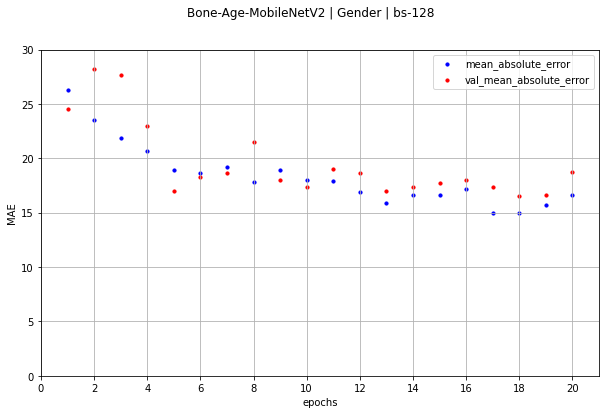

In [ ]:
plot_hist(df_hist_model, model_name, version, gender=True, batch_size=batch_size)

In [ ]:
model.summary()

Model: "Bone-Age-MobileNetV2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              